# Milestone Project 1: Food Vision Big

## Check GPU
In order to use mixed precision training, we need access to a Card with a Compute-Capability over 7+ (see here https://developer.nvidia.com/cuda-gpus)

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1050 (UUID: GPU-0ca3a9ef-dc58-0ce6-e857-0a1106ed4ced)


## Get helper functions

In the past modules we used a bunch of helper functions to do small tasks required for the notebooks.

Rather than rewrite all of these, we can import them from an external file.

In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data
Overview of TensorFlow Datasets (TFDS), read the guide https://www.tensorflow.org/datasets/overview

In [4]:
# get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available TFDS
print(len(datasets_list), "Datasets available")
print("food101" in datasets_list) # is our target dataset in list of TFDS datasets?

352 Datasets available
True


In [7]:
# Load in the data (takes a few minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            data_dir="/dataset/",
                                            shuffle_files=True,
                                            as_supervised=True, # data gets returned in tuple format (data, label)
                                            with_info=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling \dataset\food101\2.0.0.incompleteIHU8T5\food101-train.tfrecord*...:   0%|          | 0/75750 [00:00<…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling \dataset\food101\2.0.0.incompleteIHU8T5\food101-validation.tfrecord*...:   0%|          | 0/25250 [0…

Dataset food101 downloaded and prepared to /dataset/food101\2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

Want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of the input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names

In [14]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [15]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [17]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [18]:
# What does one sample of the training data look like
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [40]:
# Output info about the training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 16
    Class name (str form): cheesecake
    


In [41]:
# What does the image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [42]:
# What are the min and max values of the image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

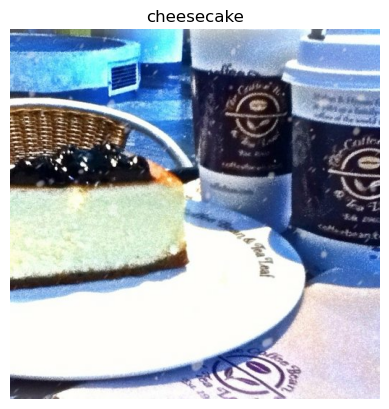

In [43]:
### Plot an image from TensorFlow Dataset
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False)

## Create preprocessing functions for the data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc)

However, not all data (including data from TensorFlow Datasets) comes like this

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to the data.

What we know about the data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What the models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, Tensorflow likes all the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called tensors generally perform better


The preprocessing function has to cover this things

EfficientNetBX is used pretrained from tf.keras.applications we dont need to rescale the data (these architectures have rescaling built-in).

This means our functions need to:
1. Reshape the images to all the same size
2. Convert the dtype of the image tensors from `uint8` to `float32`

In [60]:
# (image, label)

In [50]:
# Make a function for preprocessing iamges
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
    #image = image/255. # scale image values (not required with EfficientNetBX models)
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [51]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

Make data input pipeline run really fast.

Guide: https://www.tensorflow.org/guide/data_performance

In [56]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # as the funciton runs, tf chooses how many processors are running
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
train_data, test_data

(<PrefetchDataset shapes: ((None, None, 224, 224, 3), (None, None)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, None, 224, 224, 3), (None, None)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocessing_img`) across the training data, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current btach"

## Create modelling callbacks

Create a couple of callbacks to help while the model trains:
* TensorBoard callback to log training results (to visualize them later if need be)
* ModelCheckpoint callback to save the model's progress after feature extraction

In [63]:
# create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor="val_acc",
                                                     save_best_only=True, # best on monitor value (val_acc)
                                                     save_weights_only=True,
                                                      verbose=1 # don't print wether or not model is being saved
                                                     )

## Setup mixed precision training

For a deeper understanding of mixed precision training, TensorFlow guide: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.
Can result in a 3x speed up on modern GPUs

In [66]:
# Downgrade Tensorflow Version (run this in Google Colab) 
"""
!pip install tensorflow==2.4.1
import tensorflow as tf
tf.__version__

"""

'\n!pip install tensorflow==2.4.1\nimport tensorflow as tf\ntf.__version__\n\n'

In [68]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [70]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [73]:
from tensorflow.keras import layers

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# EfficientNetBX models have rescaling built-in
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference (not trainable) mode stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [74]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [72]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=16>